<a href="https://colab.research.google.com/github/vishal-burman/PyTorch-Architectures/blob/master/research/modeling_VariationalAutoEncoder/test_sample_ConvolutionalVariationalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/vishal-burman/PyTorch-Architectures.git
%cd PyTorch-Architectures/research/modeling_VariationalAutoEncoder/

fatal: destination path 'PyTorch-Architectures' already exists and is not an empty directory.
/content/PyTorch-Architectures/research/modeling_VariationalAutoEncoder


In [2]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from model_cvae import ConvVariationalAutoEncoder

if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True

In [3]:
##############
# Settings
##############

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)

# Hyperparameters
RANDOM_SEED = 0
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
BATCH_SIZE = 128

# Architectures
NUM_FEATURES = 784
NUM_LATENT = 15

Device:  cpu


In [4]:
# MNIST Dataset
train_dataset = datasets.MNIST(root="data",
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
valid_dataset = datasets.MNIST(root="data",
                               train=False,
                               transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

# Sanity Check
for images, labels in train_loader:
  print('Images Dimensions: ', images.shape)
  print('Labels Dimensions: ', labels.shape)
  break

Images Dimensions:  torch.Size([128, 1, 28, 28])
Labels Dimensions:  torch.Size([128])


In [5]:
torch.manual_seed(RANDOM_SEED)
model = ConvVariationalAutoEncoder(num_features=NUM_FEATURES, num_latent=NUM_LATENT)
model.to(device)

ConvVariationalAutoEncoder(
  (enc_conv_1): Conv2d(1, 16, kernel_size=(6, 6), stride=(2, 2))
  (enc_conv_2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (enc_conv_3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (z_mean): Linear(in_features=256, out_features=15, bias=True)
  (z_log_var): Linear(in_features=256, out_features=15, bias=True)
  (dec_linear_1): Linear(in_features=15, out_features=256, bias=True)
  (dec_deconv_1): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec_deconv_2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
  (dec_deconv_3): ConvTranspose2d(16, 1, kernel_size=(6, 6), stride=(3, 3), padding=(4, 4))
)

In [6]:
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable Parameters: ', params)

Trainable Parameters:  45887


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [8]:
start_time = time.time()
for epoch in range(NUM_EPOCHS):
  for batch_idx, (features, targets) in enumerate(train_loader):
    features = features.to(device)

    z_mean, z_log_var, encoded, decoded = model(features)
    kl_divergence = (0.5 * (z_mean ** 2 + torch.exp(z_log_var) - z_log_var - 1)).sum()
    pixelwise_bce = F.binary_cross_entropy(decoded, features, reduction='sum')
    cost = kl_divergence + pixelwise_bce

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # LOGGING
    if batch_idx % 50 == 0:
      print('Epoch: %04d/%04d || Batch: %04d/%04d || Loss: %.2f' % (epoch+1, NUM_EPOCHS, batch_idx, len(train_loader), cost.item()))
  epoch_elapsed_time = (time.time() - start_time) / 60
  print('Epoch Elapsed Time: %.2f min' % (epoch_elapsed_time))
total_training_time = (time.time() - start_time) / 60
print('Total Training Time: %.2f min' % (total_training_time))

Epoch: 0001/0050 || Batch: 0000/0469 || Loss: 70513.42
Epoch: 0001/0050 || Batch: 0050/0469 || Loss: 69363.09
Epoch: 0001/0050 || Batch: 0100/0469 || Loss: 42284.90
Epoch: 0001/0050 || Batch: 0150/0469 || Loss: 32887.03
Epoch: 0001/0050 || Batch: 0200/0469 || Loss: 29417.67
Epoch: 0001/0050 || Batch: 0250/0469 || Loss: 26968.47
Epoch: 0001/0050 || Batch: 0300/0469 || Loss: 27018.88
Epoch: 0001/0050 || Batch: 0350/0469 || Loss: 26208.75
Epoch: 0001/0050 || Batch: 0400/0469 || Loss: 25373.79
Epoch: 0001/0050 || Batch: 0450/0469 || Loss: 25472.05
Epoch Elapsed Time: 0.48 min
Epoch: 0002/0050 || Batch: 0000/0469 || Loss: 24636.04
Epoch: 0002/0050 || Batch: 0050/0469 || Loss: 25010.34
Epoch: 0002/0050 || Batch: 0100/0469 || Loss: 23537.40
Epoch: 0002/0050 || Batch: 0150/0469 || Loss: 24057.33
Epoch: 0002/0050 || Batch: 0200/0469 || Loss: 23329.07
Epoch: 0002/0050 || Batch: 0250/0469 || Loss: 23661.77
Epoch: 0002/0050 || Batch: 0300/0469 || Loss: 23063.80
Epoch: 0002/0050 || Batch: 0350/0469

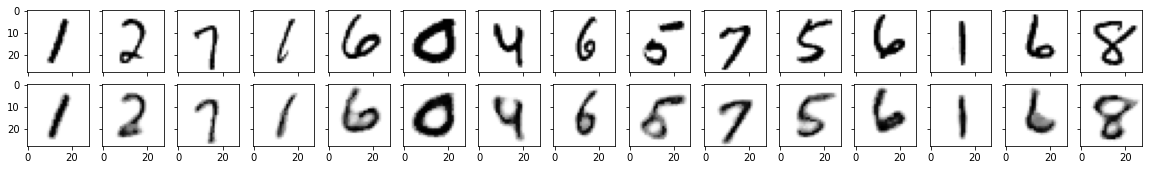

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].imshow(img[i].detach().to(torch.device('cpu')).reshape((image_width, image_width)), cmap='binary')